# The Simple Perceptron

The simple perceptron is a 1-layer feedforward network. It has one input layer, one output layer, and one connection matrix in between. Let the values of the input units be denoted by $S_i$ for $i = 1, \cdots, N$, and that for the output units be $R_j$ for $j = 1, \cdots, K$. Note that the number of input units, or the size of the input layer, does not have to be equal to that of the output, i.e., $N \neq K$, so the connection matrix $W_{ji}$ does not need to be square. For given values of the input, the output of the network is given by:
\begin{equation}
R_j = g \Big( \sum_i W_{ji} S_i \Big)
\end{equation}
where $g(\cdot)$ is the activation function. It can be a threshold function like $g(x) = \operatorname{sgn}(x)$, or simply a linear function $g(x) = x$, or a nonlinear function such as $g(x) = \tanh(x)$.

The goal of a perceptron network is to store input-output pairs. Let us label such pairs of patterns by an index $\mu = 1, \cdots, M$. Let an input pattern be $\xi^\mu$, which is an $N$-dimensional vector with components $\xi^\mu_i$; let the corresponding output pattern be $\zeta^\mu$, which is an $K$-dimensional vector with components $\zeta^\mu_j$. We would like to train the network so that, when presented $\xi^\mu$ as the input, the network will output $\zeta^\mu$. That is, we would like to have:
\begin{equation}
\zeta^\mu_j = g \Big( \sum_i W_{ji} \xi^\mu_i \Big) \quad \textsf{for all $\mu$}
\end{equation}
The challenge is to find a connection matrix $W_{ji}$ that satisfies these equations.

It turns out that there is a simple expression for $W_{ji}$ when $M \leq N$:
\begin{equation}
W_{ji} = \frac{1}{N} \sum_{\mu\nu} \zeta^\mu_j \big( Q^{-1} \big)_{\mu\nu} \, \xi^\nu_i
\quad \textsf{where} \quad
Q^{\mu\nu} = \frac{1}{N} \sum_i \xi^\mu_i \xi^\nu_i
\end{equation}
The matrix $Q^{\mu\nu}$ can be viewed as the cross-correlation between the input patterns. If the patterns are largely uncorrelated, like when they are chosen at random, then $\mathbf{Q} \approx \mathbf{I}$, the identity matrix, so the connection matrix simplifies to:
\begin{equation}
W_{ji} \approx \frac{1}{N} \sum_\mu \zeta^\mu_j \xi^\mu_i
\end{equation}

This expression may be reminiscent of the Hopfield model, except that here the input and output patterns are not the same. Another difference between the perceptron and the Hopfield network is that, in the Hopfield network, we used discrete units $S_i = \pm 1$ (recall that the images we stored were black and white). We may still do that for the perceptron, by using the threshold activation function $g(x) = \operatorname{sgn}(x)$. However, we can also use continuous-valued units for the perceptron (therefore we can now use gray-scale images, as shown below). For simplicity we can use the linear activation function $g(x) = x$. The connection matrix above works for both the threshold and linear units, as long as the number of input-output pairs to be stored is less than $N$.

Let us implement the perceptron network as follows. We will first define a base class for a general 1-layer feedforward network.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class FeedforwardNetwork:
    """
    base class of 1-layer feedforward network.
    """

    def __init__(self, Ni, No, input=None, connection=None, activation='threshold'):
        """
        declare internal variables.
        inputs:
        Ni: int, number of input nodes.
        No: int, number of output nodes.
        input: 1-d array, input nodes (can be pointer to array).
        connection: 2-d array, connection matrix between input and output nodes.
        activation: 'threshold'|'linear'|other, activation function, can be user-supplied.
        """
        self.Ni = int(Ni)    # number of input nodes
        self.No = int(No)    # number of output nodes
        self.input = np.zeros(self.Ni)    # input nodes
        self.output = np.zeros(self.No)    # output nodes
        self.connection = np.zeros((self.No, self.Ni))    # connection matrix
        self.set_network(input, connection)    # set input and connections if given
        self.set_units(activation)    # set activation function

    def set_network(self, input=None, connection=None):
        """
        set input and connection of the network.
        inputs:
        input: 1-d array, state of input nodes (can be pointer to array).
        connection: 2-d array, connection matrix.
        """
        if input is not None:
            self.input = input
        if connection is not None:
            self.connection = np.asarray(connection, dtype=float)
    
    def set_units(self, activation):
        """
        set activation function.
        inputs:
        activation: 'threshold'|'linear'|other, activation function, can be user-supplied.
        """
        if activation == 'threshold':    # using discrete units +-1
            self.activation = np.sign    # `np.sign` without the brackes is a function object
        elif activation == 'linear':    # using linear units
            self.activation = lambda x: x    # lambda function that simply returns the input
        else:
            self.activation = activation    # `activation` can be a user-defined function handle
    
    def run(self, input=None):
        """
        run network to generate output, using input if given.
        inputs:
        input: 1-d array, state of input nodes.
        outputs:
        output: 1-d array, state of output nodes.
        """
        if input is not None:
            self.input[:] = input
        self.output[:] = self.activation(np.dot(self.connection, self.input))
        return self.output

## Prescribing weights

We can define a derived class to implement the simple perceptron network. We will define a function `store()` that calculates the connection matrix for storing the input-output pairs. 

In [3]:
class SimplePerceptron(FeedforwardNetwork):
    """
    simple perceptron as a 1-layer feedforward network.
    """
    
    def store(self, inputs, outputs):
        """
        store input/output pairs by calculating the connection matrix.
        inputs:
        inputs: 2-d array, each row is an input pattern.
        outputs: 2-d array, each row is an output pattern.
        """
        inputs = np.asarray(inputs)
        outputs = np.asarray(outputs)
        corr = np.dot(inputs, inputs.T) / self.Ni
        dual = np.linalg.solve(corr, inputs)
        self.connection = np.dot(outputs.T, dual) / self.Ni

Let us create a network to "remember" the names of our guests. The input to the network will be the images we used before for the Hopfield network, except that now we can use the gray-scale versions if we use linear units in the network.

In [4]:
def grayscale(img):
    """
    convert RGB image (3d-array) to grayscale (2d-array).
    input:
    img: 3d array, last axis is RGB channel; if 2d array, then assume it is already grayscale.
    output:
    gray: 2d array, grayscale image.
    """
    if np.ndim(img) == 3 and np.shape(img)[2] >= 3:
        gray = np.sum(img[:,:,:3] * np.array([0.2989, 0.5870, 0.1140]), axis=2)
    else:
        gray = img
    # gray = gray / np.amax(gray)
    return gray

def blackwhite(gray):
    """
    convert grayscale image to black & white.
    input:
    gray: 2d array, grayscale image.
    output:
    bw: 2d array, black & white image.
    """
    med = np.median(gray)
    bw = (gray > med).astype(float)
    return bw

def img2vec(img):
    """
    convert a 2D black & white image to a 1D vector of +/-1.
    input:
    img: 2d-array of binary numbers (0 for black and 1 for white);
         some grayscale images have an extra dimension which is redundant and will be removed.
    output:
    vec: 1d-array of +/-1 values.
    """
    vec = np.reshape(img, -1)    # flatten array
    vec = 1-2*vec    # convert from 0/1 to +/-1
    return vec

def vec2img(vec, shape):
    """
    convert a 1D vector of +/-1 to a 2D black & white image.
    input:
    vec: 1d-array of +/-1 values.
    shape: 2-tuple, shape of the 2d-array.
    output:
    img: 2d-array of binary numbers (0 for black and 1 for white).
    """
    vec = (1-vec)/2
    img = np.reshape(vec, shape)
    return img

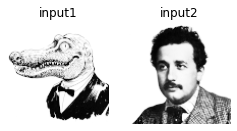

In [5]:
img1 = plt.imread('source/AlbertGator_grayscale.png')
img2 = plt.imread('source/AlbertEinstein_grayscale.png')
img1 = grayscale(img1)    # make sure the image is grayscale
img_all = [img1, img2]
M = len(img_all)

fig, ax = plt.subplots(1,M, figsize=(2*M,2))
for m in range(M):
    ax[m].imshow(img_all[m], cmap='Greys_r')    # pixel values: 0 = black, 1 = white
    ax[m].axis('off')
    ax[m].set_title(f'input{m+1}')
plt.show()

For the output, we will make some namecards for the guests. These are also gray-scale images, but of a different size from the input images. This is to remind us that the input and output layers do not have to be the same size.

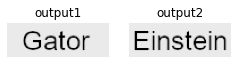

In [6]:
name1 = plt.imread('source/Gator_grayscale.png')
name2 = plt.imread('source/Einstein_grayscale.png')
name1 = grayscale(name1)    # make sure the image is grayscale
name_all = [name1, name2]

fig, ax = plt.subplots(1,M, figsize=(2*M,2))
for m in range(M):
    ax[m].imshow(name_all[m], vmin=0, vmax=1, cmap='Greys_r')    # pixel values: 0 = black, 1 = white
    ax[m].axis('off')
    ax[m].set_title(f'output{m+1}')
plt.show()

We have to convert both input and output images to 1-d arrays. Then we use the network to store these pairs of patterns.

In [7]:
shape_in = img1.shape    # shape of input image
Ni = np.prod(shape_in)    # size of input pattern
inputs = []
for img in img_all:
    inp = img2vec(img)
    inputs.append(inp)

shape_out = name1.shape    # shape of output image
No = np.prod(shape_out)    # size of output pattern
outputs = []
for name in name_all:
    out = img2vec(name)
    outputs.append(out)

In [8]:
net = SimplePerceptron(Ni, No, activation='linear')    # create perceptron network
net.store(inputs, outputs)    # store pairs of patterns

Let us test the network by making it "recall" the name of our first guest.

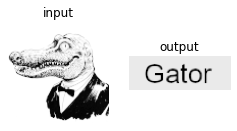

In [9]:
inp = img2vec(img1)    # first image as input pattern
out = net.run(inp)    # generate output
name = vec2img(out, shape_out)    # convert output back to image

fig, ax = plt.subplots(1, 2, figsize=(4,2))
ax[0].imshow(img1, cmap='Greys_r')
ax[0].axis('off')
ax[0].set_title('input')
ax[1].imshow(name, vmin=0, vmax=1, cmap='Greys_r')
ax[1].axis('off')
ax[1].set_title('output')
plt.show()

## Learning

The above expression for the connection matrix works precisely for linear units. Such a simple perceptron can store up to $N$ pairs of input and output patterns (recall that $N$ is the dimension of the input vector). The reason is that if we have more than $N$ input vectors, they simply cannot be independent of each other. However, it turns out that, if we use threshold units with discrete values, the storage capacity can go up to $2N$. The problem is, the above expression for the connection matrix no longer works. Therefore, we need a different way of finding a suitable connection matrix.

This leads us to studying the "learning rules" for a network. In other words, we do not specify the connection matrices beforehand, but instead let the network learn from examples. Here we will use "supervised online learning", as we will present the network with sample inputs and the correct outputs, one pair at a time (these are called "training data"). The hope is that the network uses certain rules to update its connection matrix, which eventually converges to a working solution.

For the simple perceptron, there is a simple learning rule. Suppose at one time the network is presented with the input pattern $\xi^\mu$, and with its current connection matrix $W_{ki}$ it outputs
\begin{equation}
R_k = g \Big( \sum_i W_{ki} \xi^\mu_i \Big)
\end{equation}
which may be different from the target output $\zeta^\mu$. The learning rule is to update the connection matrix by:
\begin{equation}
\Delta W_{ki} = \eta \, (\zeta^\mu_k - R_k) \, \xi^\mu_i
\end{equation}
Here $\eta$ is a small positive number called the "learning rate". It can be shown that, after presenting the network repeatedly with the input and output patterns, the network will find an appropriate connection matrix.

Let us test this learning rule. We first have to add it to our `SimplePerceptron` class as a new function, which will be called `train()`. This function takes two arguments, an input pattern and its associated output pattern.

In [10]:
class SimplePerceptron(FeedforwardNetwork):
    """
    simple perceptron as a 1-layer feedforward network.
    """
    
    def store(self, inputs, outputs):
        """
        store input/output pairs by calculating the connection matrix.
        inputs:
        inputs: 2-d array, each row is an input pattern.
        outputs: 2-d array, each row is an output pattern.
        """
        inputs = np.asarray(inputs)
        outputs = np.asarray(outputs)
        corr = np.dot(inputs, inputs.T) / self.Ni
        dual = np.linalg.solve(corr, inputs)
        self.connection = np.dot(outputs.T, dual) / self.Ni
    
    def train(self, input, output, learning_rate=None):
        """
        train network using the perceptron learning rule.
        inputs:
        input: 1-d array, given input values from training data.
        output: 1-d array, target output values from training data.
        learning_rate: float, learning rate, should be a small number.
        """
        if learning_rate is None:
            learning_rate = 1/self.Ni
        out = self.run(input)    # generate output with current connections
        diff = output - out    # difference between target output and current output
        self.connection += learning_rate * diff[:,np.newaxis] * input    # simple perceptron learning rule

Let us train a new network with the learning rule.

In [11]:
net = SimplePerceptron(Ni, No)    # create perceptron network

T = 200    # training time
seq = np.random.randint(M, size=T)    # random sequences of input patterns

for s in seq:
    net.train(inputs[s], outputs[s])    # present an input-output pair every time

Now we can test the network on our other guest.

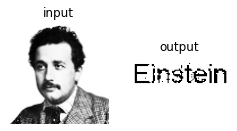

In [12]:
inp = img2vec(img2)    # second image as input pattern
out = net.run(inp)    # generate output
name = vec2img(out, shape_out)    # convert output back to image

fig, ax = plt.subplots(1, 2, figsize=(4,2))
ax[0].imshow(img, cmap='Greys_r')
ax[0].axis('off')
ax[0].set_title('input')
ax[1].imshow(name, vmin=0, vmax=1, cmap='Greys_r')
ax[1].axis('off')
ax[1].set_title('output')
plt.show()

You can see that the network is already performing pretty well. If we train the network with more data, the performance may further improve. (There may be times when the training fails, as the process is stochastic; run again if that happens.)